In [1]:
import os; os.chdir('..'); os.getcwd()

'/home/jupyter/master-thesis/src'

In [2]:
from jobs.specs.__dev import aetarn_smth_dev as opts
from models.ae_tarn import AETimeAlignedResNet
from pipeline.smth.databunch import SmthDataBunch
from models.engine import _prepare_batch
import constants as ct

import dataclasses as dc
import torch as th
import matplotlib.pyplot as plt
import numpy as np


In [3]:
def pic_show(_video):
    num = len(_video)
    fig = plt.figure(figsize=(16, 32), dpi=80)
    for i in range(1,num+1):
        sub = fig.add_subplot(1,num,i)
        sub.set_title(str(i))
        sub.axis('off')
        sub.imshow(_video[i-1])
    plt.show()

def un_normalize(_x):
    return _x * 255

def un_standardize(_x):
    means = th.tensor(ct.IMAGE_NET_MEANS).reshape((1, 3, 1, 1))
    stds = th.tensor(ct.IMAGE_NET_STDS).reshape((1, 3, 1, 1))
    
    return _x * stds + means

In [4]:
opts.trainer_opts.optimizer_opts.lr = 0.001
opts.valid_dl_opts.batch_size = 1
opts.dev_dl_opts.batch_size = 1
opts.trainer_opts.criterion_opts.mse_factor = 1.0
opts.trainer_opts.criterion_opts.ce_factor = 1.0
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

model = AETimeAlignedResNet(**dc.asdict(opts.model_opts)).to(device)
bunch = SmthDataBunch(opts.db_opts, opts.train_ds_opts, opts.dev_ds_opts, opts.valid_ds_opts, 
                      opts.train_dl_opts, opts.dev_dl_opts, opts.valid_dl_opts)
optimizer = opts.trainer_opts.optimizer(model.parameters(), **dc.asdict(opts.trainer_opts.optimizer_opts))
loss_fn = opts.trainer_opts.criterion(**dc.asdict(opts.trainer_opts.criterion_opts)).to(device)

# model.load_state_dict(th.load('../runs/dummy/smth/__dev/aetarn_smth_dev@1.0_1.0/best_model_44_acc@1=0.4027.pth', 
#                               map_location=device), strict=False)


In [5]:

batch = next(iter(bunch.valid_loader))
video, label = bunch.valid_set[0]
x, y = _prepare_batch(batch, device, False)


In [6]:

video, label


(Video 172305 (4x3x224x224), (6 Throwing something))

In [7]:

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    _pred, _embed, _recon = model(x, inference=False)
    mse, ce = loss_fn(_recon, _pred.reshape(1, 30), x, y)
    (mse + ce).backward()
    print(f'EPOCH={epoch:03d} | CE={ce:.4f} | MSE={mse:.4f}')
    optimizer.step()


EPOCH=000 | CE=11.1986 | MSE=0.5818
EPOCH=001 | CE=0.6020 | MSE=0.4692
EPOCH=002 | CE=2.9729 | MSE=0.3857
EPOCH=003 | CE=0.0000 | MSE=0.3323
EPOCH=004 | CE=0.0433 | MSE=0.2802
EPOCH=005 | CE=3.5944 | MSE=0.2429
EPOCH=006 | CE=0.0007 | MSE=0.2234
EPOCH=007 | CE=0.0000 | MSE=0.2051
EPOCH=008 | CE=0.0008 | MSE=0.1890
EPOCH=009 | CE=0.0123 | MSE=0.1750
EPOCH=010 | CE=0.0045 | MSE=0.1618
EPOCH=011 | CE=0.0057 | MSE=0.1502
EPOCH=012 | CE=0.0000 | MSE=0.1408
EPOCH=013 | CE=0.0010 | MSE=0.1327
EPOCH=014 | CE=0.0041 | MSE=0.1264
EPOCH=015 | CE=0.0000 | MSE=0.1195
EPOCH=016 | CE=0.1425 | MSE=0.1121
EPOCH=017 | CE=0.0000 | MSE=0.1056
EPOCH=018 | CE=0.0000 | MSE=0.1009
EPOCH=019 | CE=0.0000 | MSE=0.0960
EPOCH=020 | CE=0.0034 | MSE=0.0911
EPOCH=021 | CE=0.0000 | MSE=0.0866
EPOCH=022 | CE=0.0000 | MSE=0.0815
EPOCH=023 | CE=0.0001 | MSE=0.0775
EPOCH=024 | CE=0.0000 | MSE=0.0739
EPOCH=025 | CE=0.0000 | MSE=0.0697
EPOCH=026 | CE=0.0000 | MSE=0.0659
EPOCH=027 | CE=0.0000 | MSE=0.0626
EPOCH=028 | CE=0.00

In [8]:

model.eval()
_pred, _embed, _recon = model(x, inference=True)


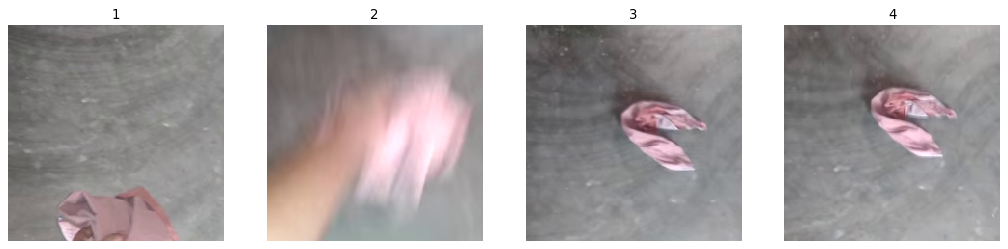

In [9]:

_in = video.data.astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_in)


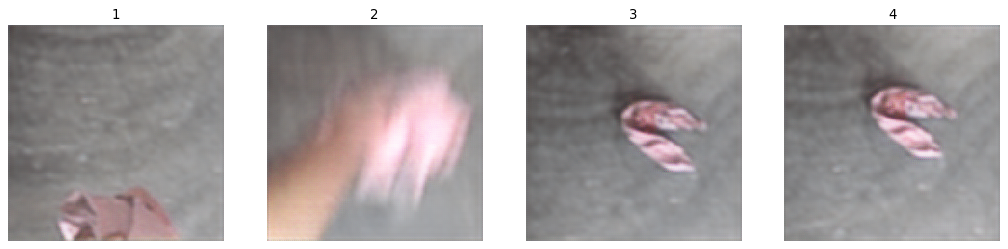

In [10]:

_rec = un_normalize(un_standardize(_recon.detach().cpu()))
_rec = _rec.numpy().reshape(4, 3, 224, 224).astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_rec)


In [11]:

_recon.min(), _recon.max(), _rec.min(), _rec.max()


(tensor(-1.2121, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(2.5859, device='cuda:0', grad_fn=<MaxBackward1>),
 47,
 254)

In [12]:

un_standardize(_recon.detach().cpu()).min(), un_standardize(_recon.detach().cpu()).max()


(tensor(0.1845), tensor(0.9999))